In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib

In [23]:
# Load train and test datasets
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")


if 'timestamp' in train_df.columns:
    train_df = train_df.drop(columns=['timestamp'])


if 'timestamp' in test_df.columns:
    test_df = test_df.drop(columns=['timestamp'])

In [25]:
# Columns to be used as features and target
feature_cols = [
    "open", "high", "low", "close", "volume", "hour", "day_of_week", "month", 
    "avg_100_candles", "std", "ema_20", "ema_100", "rsi_20", "macd_line", 
    "macd_signal", "bollinger_upper", "bollinger_lower", "bollinger_bandwidth", 
    "volume_100"
]
target_col = "next_close"

# Prepare features (X) and target (y)
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

In [27]:
# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [29]:
params = {
    "objective": "reg:squarederror",  # Regression objective
    "max_depth": 6,                  # Maximum depth of trees
    "eta": 0.1,                      # Learning rate
    "subsample": 0.8,                # Subsample ratio of training data
    "colsample_bytree": 0.8,         # Subsample ratio of columns when constructing trees
    "eval_metric": "rmse"           # Evaluation metric
}


# Train the model
print("Training the model...")
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

Training the model...


In [31]:
# Predict on the test set
y_pred = model.predict(dtest)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Model Evaluation:
RMSE: 0.01
R² Score: 1.00


In [49]:
# View a few predictions vs actual values
results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).reset_index(drop=True)
print("Sample Predictions:")
print(results.head())

Sample Predictions:
     Actual  Predicted
0  1.454938   1.462829
1  0.594272   0.600532
2  1.559389   1.562253
3 -1.236203  -1.233808
4  1.061758   1.090530


<Axes: title={'center': 'Top 10 Feature Importances'}, xlabel='F score', ylabel='Features'>

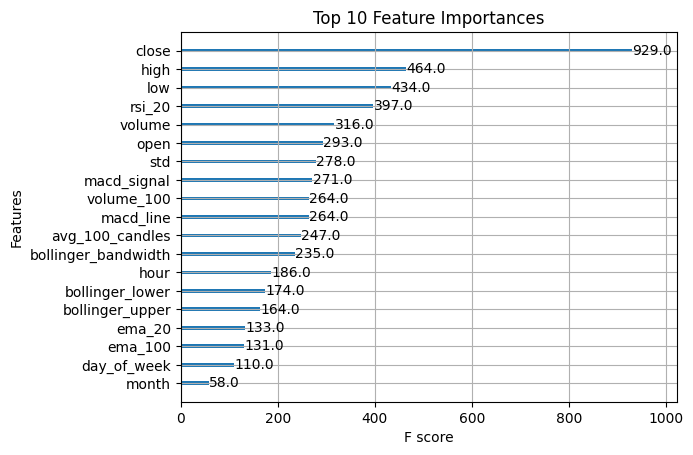

In [51]:
# Plot feature importance
xgb.plot_importance(model, importance_type="weight", max_num_features=19, title="Top 10 Feature Importances")


In [37]:
# Save the trained model
joblib.dump(model, "../xgb_model.pkl")
print("Model saved as 'xgb_model.pkl'.")

Model saved as 'xgb_model.pkl'.


In [53]:
import json

# Load scaling parameters
with open("../data/scaling_params.json", "r") as f:
    scaling_params = json.load(f)

# Assuming `results` is a DataFrame containing 'Predicted' and 'Actual' columns
# Unnormalize the 'Actual' and 'Predicted' values
mean = scaling_params["next_close"]["mean"]
std = scaling_params["next_close"]["std"]

results["Actual"] = results["Actual"] * std + mean
results["Predicted"] = results["Predicted"] * std + mean

# Save results to a CSV file
results.to_csv("../data/test_results.csv", index=False)
print("Test results saved as 'test_results.csv'.")

Test results saved as 'test_results.csv'.


In [57]:
# Calculate the unnormalized MSE
mse_unnormalized = mean_squared_error(
    results["Actual"], results["Predicted"]
)

# Print the unnormalized MSE
print(f"Unnormalized MSE: {mse_unnormalized}")
print(f"Unnormalized RMSE: {mse_unnormalized**0.5}")

Unnormalized MSE: 84126.17621667069
Unnormalized RMSE: 290.04512789679933


In [79]:
print(f"Model Evaluation:")
print(f"R² Score: {r2:.2f}")
print(f"Unnormalized RMSE: {mse_unnormalized**0.5}")
print("Random sample from the test results: ")
results.sample(n=5)

Model Evaluation:
R² Score: 1.00
Unnormalized RMSE: 290.04512789679933
Random sample from the test results: 


,Actual,Predicted
1058,62510.2,62441.734375
1753,22825.7,22907.386719
619,37581.0,37723.636719
998,16909.0,16825.759766
356,97265.1,97370.492188
